In [1]:
%pip install -q otter-grader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 20.9 MB/s eta 0:00:00


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/porrashuang/CSE6740_CDA_HW1_Tests.git tests
else:
    print("Not running in Colab")

import otter
grader = otter.Notebook()


Cloning into 'tests'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 33 (delta 26), reused 12 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 15.24 KiB | 3.81 MiB/s, done.
Resolving deltas: 100% (26/26), done.


# Task 1: K-Means Clustering (20 pts)

## Goal
Implement a complete K-means clustering algorithm from scratch and test it on real data.

### Core Functions
1. **Distance calculation** - Compute Euclidean distance between points
2. **Find nearest centroid** - Determine which centroid is closest to a given point  
3. **Update assignments** - Assign all data points to their nearest centroids
4. **Update centroids** - Recalculate centroid positions based on assigned points
5. **Full K-means algorithm** - Combine everything with proper initialization and convergence

### Testing
Your implementation will be tested on the digits dataset to see how well it can identify different digit clusters compared to random guessing.

## Evaluation
- All functions work correctly and pass unit tests
- K-means achieves better clustering than random assignment on MNIST dataset



In [3]:
def distance_euclidean(a, b):
    """Compute the Euclidean distance between two points a and b.
    Input: a, b: numpy arrays of shape (d,)
    Output: Euclidean distance between a and b.
    """
    return np.linalg.norm(a - b, 2)
    ...


In [4]:
grader.check("distance_euclidean")

distance_euclidean results: All test cases passed!

In [5]:
def find_closest_centroid(x, centroids):
    """Find the index of the closest centroid to point x.
    Input: x: numpy array of shape (d,)
           centroids: numpy array of shape (k, d) where each row is a centroid
    Output: index of the closest centroid to x.
    """
    distances = np.linalg.norm(centroids - x, axis=1)
    return np.argmin(distances)

In [6]:
grader.check("find_closest_centroid")

find_closest_centroid results: All test cases passed!

In [7]:
def update_assignments(X, centroids):
       """Update the cluster assignments for each point in X.
       Input: X: numpy array of shape (n, d)
                 centroids: numpy array of shape (k, d)
       Output: numpy array of shape (n,) containing the index of the closest centroid for each point
       """
       distances = np.linalg.norm(centroids[:, np.newaxis] - X, axis=2)
       return np.argmin(distances, axis=0)


In [8]:
grader.check("update_assignments")

update_assignments results: All test cases passed!

In [9]:
def update_centroids(X, assignments):
    """
    Update centroids by computing the mean of all points assigned to each centroid.
    Input:
        X: numpy array of shape (n, d)
        assignments: numpy array of shape (n,) with cluster indices (0..k-1)

    ***** Note *******
    In order to make the result deterministic, initialize centroids with zeros.
    For centroids with no assignment, remove them.
    **** End Note ****

    Output:
        centroids: numpy array of shape (k, d)
    """
    unique_clusters = np.unique(assignments)
    centroids = np.zeros((len(unique_clusters), X.shape[1]))

    for i in range(len(unique_clusters)):
      centroids[i] = np.mean(X[assignments == unique_clusters[i]], axis=0)
    return centroids


In [10]:
grader.check("update_centroids")

update_centroids results: All test cases passed!


The evaluation process for K-means clustering on MNIST digits dataset follows these key steps:

### 1. Data Loading & Preprocessing
We will load the digits dataset (8x8 images of handwritten digits 0-9) from sklearn.datasets. We will split into training (70%) and test (30%) sets. We will use the training set to learn cluster centroids.

### 2. K-means Clustering
Run `myKmeans` on training data with k=10 clusters (one for each digit) and get the final centroids and assignments.

### 3. Cluster-to-Label Mapping
We use Hungarian algorithm https://en.wikipedia.org/wiki/Hungarian_algorithm to optimally map clusters to digit labels. In short, it tries to match the cluster assignments to the true labels by building a cost matrix based on how well each cluster represents each digit.

### 4. Test Set Prediction
We will assign test points to the nearest centroids using `update_assignments()`. Then, we will map the cluster assignments to digit labels using the mapping from step 3.

### 5. Performance Evaluation
The evaluation is done by calculating Adjusted Rand Index (ARI) between predicted and true labels and comparing against random baseline (random digit assignment). As long as the K-means ARI must exceed random ARI by 0.3, we consider it a success. The private test has the same structure but different random seed.

### 6. Visualization
At the end, we will display the 10 centroids as 8x8 images to see what each cluster learned

The evaluation shows that K-means should discover meaningful digit patterns and significantly outperform random guessing at clustering similar digits together.

In [11]:
def myKmeans(X, k, init_centroids=None, max_iters=100, epsilon=1e-4):
    """
    K-means clustering algorithm.

    Input:
        X (np.ndarray): data points, shape (n, d)
        k (int): number of clusters
        init_centroids (np.ndarray, optional): initial centroids, shape (k, d)
        max_iters (int): maximum number of iterations
        epsilon (float): convergence threshold

    Output:
        tuple: centroids (np.ndarray of shape (k, d)), assignments of each data point (np.ndarray of shape (n,))
    """
    # Initialize centroids randomly from the training data
    if init_centroids is not None:
        centroids = init_centroids
    else:
        indices = np.random.choice(X.shape[0], k, replace=False)
        centroids = X[indices].copy()

    for num in range(max_iters):
      distances = np.linalg.norm(centroids[:, np.newaxis] - X, axis=2)
      assignments = np.argmin(distances, axis=0)
      unique_clusters = np.unique(assignments)

      for i in range(len(unique_clusters)):
        centroids[i] = np.mean(X[assignments == unique_clusters[i]], axis=0)
    return (centroids, assignments)


In [12]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
def test_MNIST():
    # Load the digits dataset (acts as the MNIST dataset for demonstration)
    X, y = load_digits(return_X_y=True)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Number of clusters (10 digits)
    k = len(np.unique(y_train))


    centroids, assignments = myKmeans(X_train, k)
    # Map cluster indices to actual digit labels using the Hungarian algorithm
    train_pred_clusters = assignments
    cost_matrix = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            mask = train_pred_clusters == i
            cost_matrix[i, j] = -np.sum(y_train[mask] == j)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    cluster_to_label = {row: col for row, col in zip(row_ind, col_ind)}

    # Predict labels for the test data
    # Assign each test point to the nearest centroid
    test_pred_clusters = update_assignments(X_test, centroids)
    test_pred_labels = np.array([cluster_to_label[c] for c in test_pred_clusters])

    # Compute the Adjusted Rand Index (ARI) for the K-means predictions
    ari_score = adjusted_rand_score(y_test, test_pred_labels)

    # Baseline comparison: Random guess for each test label
    random_pred_labels = np.random.choice(np.unique(y_train), size=len(y_test))
    ari_score_random = adjusted_rand_score(y_test, random_pred_labels)

    return ari_score, ari_score_random, centroids, cluster_to_label
ari_score, ari_score_random, centroids, cluster_to_label = test_MNIST()

In [13]:
grader.check("kmeans")

kmeans results: All test cases passed!

<!-- BEGIN QUESTION -->



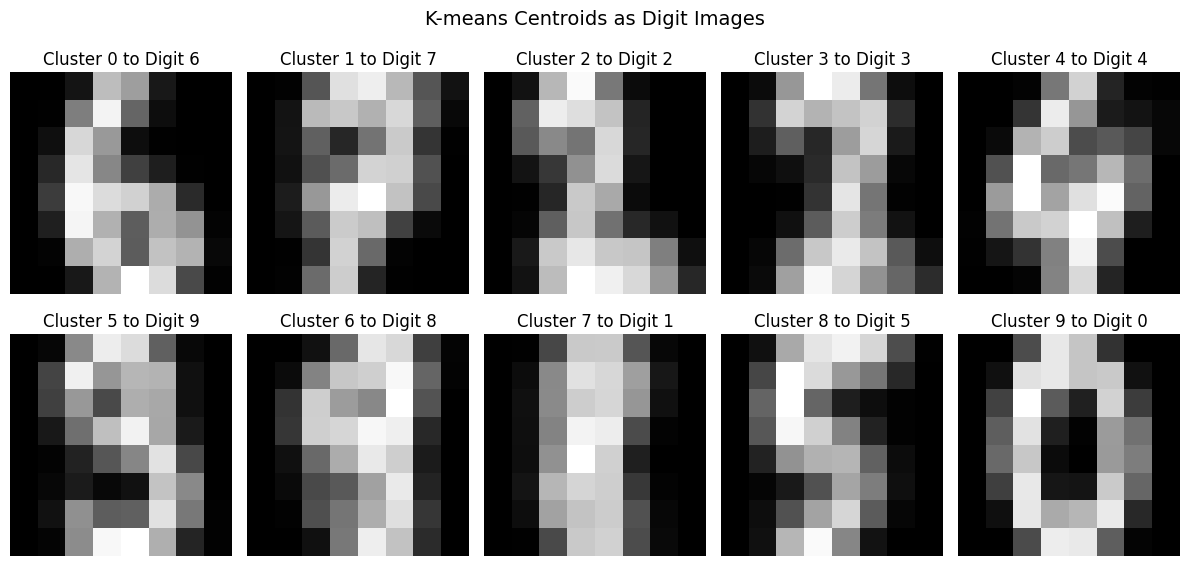

In [14]:
# Visualize the centroids as 8x8 digit images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    # Reshape centroid back to 8x8 image
    centroid_image = centroids[i].reshape(8, 8)
    axes[i].imshow(centroid_image, cmap='gray')
    # Show which digit this centroid represents
    assigned_digit = cluster_to_label.get(i, '?')
    axes[i].set_title(f'Cluster {i} to Digit {assigned_digit}')
    axes[i].axis('off')

plt.suptitle('K-means Centroids as Digit Images', fontsize=14)
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## What other ways we can initialize centroids? List at least 2 and their advantages/disadvantages. [1.5 pts]




_Type your answer here, replacing this text._

1. You can select k number of points out of the datasets as the centroids. The advantge of this is that it prevents centroids from being placed where no data exists

2. You can also assume that all the dataset is a cluster such that you have the same number of datasets as cluster. Although the accuracy might be high but it would be very computationally expensive because if the number of dataset is very high the number of cluster would be high too and this would cause overfitting as well.

<!-- END QUESTION -->

# Task 2: Three Coins Model (30 pts)

### Purpose
- Develop an intuitive understanding of the EM algorithm using a simple example.  
- Implement a basic EM algorithm to solve the three coins problem.

### Problem Statement
Consider three coins **A**, **B**, and **C**, with probabilities of landing heads denoted as $p_0$, $p_1$, and $p_2$, respectively.  

The process is as follows:
1. Flip coin **A**.  
   - If **A** shows heads, flip coin **B**.  
   - If **A** shows tails, flip coin **C**.  
2. Record the outcome of the second flip as $y_i$, where:  
   - $y_i = 1$ if the result is heads.  
   - $y_i = 0$ if the result is tails.  

Given a sequence of observed outcomes $y_0, y_1, \dots, y_n$, the task is to estimate the parameters $p_0$, $p_1$, and $p_2$ using the Expectation-Maximization (EM) algorithm.


<!-- BEGIN QUESTION -->

# Complete Data Log-Likelihood Function

Let's simplify the problem by assuming that the outcome of the first coin flip is known and denoted as $z_i$, where:

- $z_i = 1$ if coin $B$ was used,  
- $z_i = 0$ if coin $C$ was used.  

Given $z_i$ and the observed data $y_i$, can you define the log-likelihood function $L(z_i, y_i, p_0, p_1, p_2) = \log P(z_i, y_i \mid p_0, p_1, p_2)$ and implement it? [Writing is optional and won't be graded, but coding has points]

_Type your answer here, replacing this text._

<!-- END QUESTION -->



In [15]:
def compute_log_likelihood(y_i, z_i, p_0, p_1, p_2):
    """
    Compute complete-data log-likelihood for one trial.

    Input:
        y_i (int): observed result of the second toss, 1=heads, 0=tails
        z_i (int): latent branch,
                   1 if coin A=H -> coin B,
                   0 if coin A=T -> coin C
        p_0 (float): P(H on coin A)
        p_1 (float): P(H on coin B)
        p_2 (float): P(H on coin C)

    Output:
        float: log P(y_i, z_i | parameters)
    """
    if z_i == 1 and y_i == 1:
        return np.log(p_0 *p_1)
    if z_i == 1 and y_i == 0:
        return np.log(p_0 * (1 - p_1))
    if z_i == 0 and y_i == 1:
        return np.log((1-p_0) * p_2)
    if z_i == 0 and y_i == 0:
        return np.log((1-p_0) * p_2)


In [16]:
grader.check("complete-log-likelihood-coding")

complete-log-likelihood-coding results: All test cases passed!

<!-- BEGIN QUESTION -->

### Write the complete log-likelihood formula for all observations $y_0, y_1, \dots, y_n$ with corresponding latent variables $z_0, z_1, \dots, z_n$. [Optional, won't be graded]




_Type your answer here, replacing this text._

$log[\sum_{i}^{n}\sum_{i}^{n} p(z_{i}|p_o, p_1, p_2)p(y_{i}|z_{i}, p_o, p_1, p_2)]$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->


Given the observations $Y = (y_0, y_1, \dots, y_n)$ and the latent variables $Z = (z_0, z_1, \dots, z_n)$, how can we maximize the log-likelihood function $L(Y, Z, p_0, p_1, p_2)$ with respect to the parameters $p_0$, $p_1$, and $p_2$? [Optional, won't be graded]

_Type your answer here, replacing this text._

$\theta_{ml} = argmax_{\theta = p_o, p_1, p_2} L(\theta)$<br>
$\theta_{ml} = argmax_{\theta = p_o, p_1, p_2} log[\sum_{i}^{n}\sum_{i}^{n} p(z_{i}|p_o, p_1, p_2)p(y_{i}|z_{i}, p_o, p_1, p_2)]$<br>
$\theta_{ml} = \frac{\partial L(\theta)}{\partial (\theta)}$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Incomplete Data Log-Likelihood - Posterior of $z_i$
Now, let's assume that you do not know the result of the first coin $z_i$. Although you do not know the first coin result, you can still 'guess' by computing the posterior probability of $z_i$ given the observed data $y_i$ and the parameters $p_0, p_1, p_2$. From now on, we will use $\theta = (p_0, p_1, p_2)$ to denote the parameters of the model.

Let's note the latent variable as $z_i$ where $z_i = 1$ if the coin $B$ was used and $z_i = 0$ if the coin $C$ was used. We can estimate the latent variable $z_i$ given the observed data $y_i$.


 What is the posterior probability $P(z_i = 1 | y_i, \theta)$? Can you write it mathematically and implement it? [Writing is optional and won't be graded, but coding has points]


_Type your answer here, replacing this text._

$p(z_{i}=1|y_{i}, \theta) = \frac{p(z_{i}=1|y_{i}, \theta)}{p(y_{i}|\theta)}$<br>
$p(z_{i}=1|y_{i}, \theta) = \frac{p_0 * p_1}{p_0 * p_1 + (1 - p_0)*p_2}$


<!-- END QUESTION -->



In [17]:
def compute_posterior(y_i, p_0, p_1, p_2):
    """
    Compute the posterior probability P(z_i = 1 | y_i, theta)
    Input: y_i (observation), p_0 (prior for coin A), p_1 (likelihood for coin B), p_2 (likelihood for coin C)
    Output: Posterior probability P(z_i = 1 | y_i, theta)
    """
    numerator = p_0 * p_1
    denominator = (p_0 * p_1) + (1 - p_0)* (p_2)
    return numerator / denominator

In [18]:
grader.check("posterior-of-z_i-coding")

posterior-of-z_i-coding results: All test cases passed!

What is the posterior probability $P(z_i = 0 | y_i, \theta)$?

$p(z_{i}=0|y_{i}, \theta) = \frac{p(z_{i}=0|y_{i}, \theta)}{p(y_{i}|\theta)}$<br>
$p(z_{i}=0|y_{i}, \theta) = \frac{(1 - p_0) * p_2}{p_0 * p_1 + (1 - p_0)*p_2}$


In [19]:
def compute_posterior_zero(y_i, p_0, p_1, p_2):
    """
    Compute the posterior probability P(z_i = 0 | y_i, \theta)
    Input: y_i (observation), p_0 (prior for coin A), p_1 (likelihood for coin B), p_2 (likelihood for coin C)
    Output: Posterior probability P(z_i = 0 | y_i, \theta)
    """
    numerator = (1- p_0) * p_2
    denominator = (p_0 * p_1) + (1 - p_0)* (p_2)
    return numerator / denominator

In [20]:
grader.check("posterior-of-z_i-coding-zero")

posterior-of-z_i-coding-zero results: All test cases passed!

Since we do not know $z$, but from Jensen Inequality we learned in class, we can lower bound the euqation. Thus we use the posterior probability of $z$ under the current parameters to estimate the log-likelihood function. This is called the Q-function in the EM algorithm. The Q-function is defined as follows:
```math
Q(\theta | \theta_k) = \mathbb{E}_{z \sim P(z | y, \theta_k)} [\log P(y, z | \theta)]
```
Note that $\theta_k$ is the current parameter and $\theta$ is the new parameter we want to maxmize the log-likelihood for.

### E-step
Calculate the log-likelihood function $Q(p_0, p_1, p_2 | p_0^{(t)}, p_1^{(t)}, p_2^{(t)})$ using the posterior probability of $z_i$ under the current parameters $p_0^{(t)}, p_1^{(t)}, p_2^{(t)}$. The return should be log-likelihood of $p_0, p_1, p_2$ given the current parameters $p_0^{(t)}, p_1^{(t)}, p_2^{(t)}$ and observations $Y = (y_0, y_1, ..., y_n)$.

In [21]:
def Q_function(Y, p_0, p_1, p_2, p_0_t, p_1_t, p_2_t):
    """
    Compute the Q-function for the EM algorithm.

    Input:
        Y (list of int): observed results of the second toss, 1=heads, 0=tails
        p_0 (float): current estimate of P(H on coin A)
        p_1 (float): current estimate of P(H on coin B)
        p_2 (float): current estimate of P(H on coin C)
        p_0_t (float): previous estimate of P(H on coin A)
        p_1_t (float): previous estimate of P(H on coin B)
        p_2_t (float): previous estimate of P(H on coin C)

    Output:
        float: Q(p_0, p_1, p_2 | p_0_t, p_1_t, p_2_t)
    """
    Q_val = 0.0

    for y in Y:
        # Posterior for y == 1 (A->B given head)
        denom_head = (p_0_t * p_1_t) + ((1 - p_0_t) * p_2_t)
        gamma_head = (p_0_t * p_1_t) / (denom_head)

        # Posterior for y == 0 (A->B given tail)
        denom_tail = (p_0_t * (1 - p_1_t)) + ((1 - p_0_t) * (1 - p_2_t))
        gamma_tail = (p_0_t * (1 - p_1_t)) / (denom_tail)

        if y == 1:
            Q_val += gamma_head * np.log((p_0 * p_1))
            Q_val += (1 - gamma_head) * np.log(((1 - p_0) * p_2))
        else:  # y == 0
            Q_val += gamma_tail * np.log((p_0 * (1 - p_1)))
            Q_val += (1 - gamma_tail) * np.log(((1 - p_0) * (1 - p_2)))

    return Q_val


In [22]:
Y = [1, 0, 1]
p0, p1, p2 = (0.5, 0.7, 0.4)
p0_t, p1_t, p2_t = (0.6, 0.8, 0.2)
expected = -3.652547418589841

print(Q_function(Y, p0, p1, p2, p0_t, p1_t, p2_t))
# → -3.652547418589841


-3.6525474186004105


In [23]:
grader.check("q-function")

q-function results: All test cases passed!

# M-Step
Maximize the Q-function $Q(p_0, p_1, p_2 | p_0^{(t)}, p_1^{(t)}, p_2^{(t)})$ with respect to the parameters $p_0$, $p_1$, and $p_2$. The return should be the new parameters $p_0^{(t+1)}$, $p_1^{(t+1)}$, and $p_2^{(t+1)}$ that maximize the Q-function.

In [29]:
import numpy as np
import random

def update_parameters(Y, p_0, p_1, p_2):
    """
    Update the parameters of the model using EM.
    Input:
        Y (list of int): observed coin tosses (1=heads, 0=tails)
        p_0, p_1, p_2: current estimates
    Output:
        Updated parameters (p_0_new, p_1_new, p_2_new)
    """
    #N = len(Y)

    # responsibilities
    gamma_A = []  # P(Z=A | y)
    gamma_notA = []  # P(Z≠A | y)

    for y in Y:
        if y == 1:  # heads
            denom = (p_0 * p_1) + ((1 - p_0) * p_2)
            gA = (p_0 * p_1) / denom
        else:  # tails
            denom = (p_0 * (1 - p_1)) + ((1 - p_0) * (1 - p_2))
            gA = (p_0 * (1 - p_1)) / denom

        gamma_A.append(gA)
        gamma_notA.append(1 - gA)

    gamma_A = np.array(gamma_A)
    gamma_notA = np.array(gamma_notA)
    Y = np.array(Y)

    # M-step updates
    p_0_new = np.mean(gamma_A)
    p_1_new = np.sum(gamma_A * Y) / np.sum(gamma_A)
    p_2_new = np.sum(gamma_notA * Y) / np.sum(gamma_notA)

    return p_0_new, p_1_new, p_2_new


In [30]:
def estimate_parameters(Y, tol=1e-6, max_iter=1000):
    # Initialize randomly
    p_0, p_1, p_2 = random.random(), random.random(), random.random()

    for _ in range(max_iter):
        p_0_new, p_1_new, p_2_new = update_parameters(Y, p_0, p_1, p_2)

        # check convergence
        if (abs(p_0_new - p_0) < tol and
            abs(p_1_new - p_1) < tol and
            abs(p_2_new - p_2) < tol):
            break

        p_0, p_1, p_2 = p_0_new, p_1_new, p_2_new

    return p_0, p_1, p_2

In [31]:
def generate_test(p_0, p_1, p_2, n=100):
    """
    Generate a test dataset based on the given parameters.

    Input:
        p_0 (float): P(H on coin A)
        p_1 (float): P(H on coin B)
        p_2 (float): P(H on coin C)
        n (int): number of trials

    Output:
        list of int: generated observed results of the second toss
    """
    Y = []
    for _ in range(n):
        z_i = 1 if random.random() < p_0 else 0
        y_i = 1 if random.random() < (p_1 if z_i == 1 else p_2) else 0
        Y.append(y_i)
    return Y
p_0, p_1, p_2 = 0.5, 0.7, 0.4
Y_0 = generate_test(p_0, p_1, p_2, n=1000)
p_estimated_0, p_estimated_1, p_estimated_2 = estimate_parameters(Y_0)
print(f"True parameters: p_0={p_0}, p_1={p_1}, p_2={p_2}")
print(f"Estimated parameters: p_0={p_estimated_0:.4f}, p_1={p_estimated_1:.4f}, p_2={p_estimated_2:.4f}")
print("Is it a good estimation?")

True parameters: p_0=0.5, p_1=0.7, p_2=0.4
Estimated parameters: p_0=0.5289, p_1=0.9943, p_2=0.0576
Is it a good estimation?


In [32]:
grader.check("m-step")

m-step results: All test cases passed!

<!-- BEGIN QUESTION -->

# Modified Problem: 5 Flips Per Trial

In the modified version:
1. Flip coin A once
2. If A shows heads -> flip coin B **5 times**
3. If A shows tails -> flip coin C **5 times**
4. Record all 5 outcomes as a sequence: e.g., `[1, 0, 1, 1, 0]`

Now each observation `y_i` is a list of 5 outcomes instead of a single outcome. We again simply and assume we now latent variables `z_i` for each sequence of flips.
What is the complete data log-likelihood for a sequence of flips with parameter $\theta$? [Writing is optional and won't be graded, but coding has points]


_Type your answer here, replacing this text._

<!-- END QUESTION -->



In [33]:
def compute_log_likelihood_sequence(y_sequence, z_i, p_0, p_1, p_2):
    """
    Compute complete-data log-likelihood for a sequence of flips.

    Input:
        y_sequence (list): sequence of flip results, e.g., [1, 0, 1, 1, 0]
        z_i (int): latent branch, 1 if coin B, 0 if coin C
        p_0 (float): P(H on coin A)
        p_1 (float): P(H on coin B)
        p_2 (float): P(H on coin C)

    Output:
        float: log P(y_sequence, z_i | parameters)
    """
    count_ones  = y_sequence.count(1)
    count_zeros = y_sequence.count(0)
    if z_i == 1:
        return np.log(p_0 *(p_1**(count_ones) * (1 - p_1)**(count_zeros)))
    if z_i == 0:
        return np.log((1 - p_0) * (p_2**(count_ones) * (1 - p_2)**(count_zeros)))

In [34]:
grader.check("log-likelihood-sequence")

log-likelihood-sequence results: All test cases passed!

#

## Incomplete Data Log-Likelihood - Posterior of $z_i$
Again, let's assume that you do not know the result of the first coin $z_i$.
 What is the posterior probability $P(z_i = 1 | y_i, \theta)$? Can you write it mathematically and implement it? [Writing is optional and won't be graded, but coding has points]

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->



In [35]:
def compute_posterior_sequence(y_sequence, p_0, p_1, p_2):
    """
    Compute P(z_i = 1 | y_sequence) for a sequence of flips.

    Input:
        y_sequence (list): sequence of flip results
        p_0, p_1, p_2: current parameter estimates

    Output:
        float: P(z_i = 1 | y_sequence)
    """
    count_ones  = y_sequence.count(1)
    count_zeros = y_sequence.count(0)
    numerator = (p_0 *(p_1**(count_ones) * (1 - p_1)**(count_zeros)))
    denominator = (p_0 *(p_1**(count_ones) * (1 - p_1)**(count_zeros))) + ((1 - p_0) * (p_2**(count_ones) * (1 - p_2)**(count_zeros)))
    return numerator / denominator

def compute_posterior_zero_sequence(y_sequence, p_0, p_1, p_2):
    """
    Compute P(z_i = 0 | y_sequence) for a sequence of flips.
    """
    count_ones  = y_sequence.count(1)
    count_zeros = y_sequence.count(0)
    numerator = ((1 - p_0) * (p_2**(count_ones) * (1 - p_2)**(count_zeros)))
    denominator = (p_0 *(p_1**(count_ones) * (1 - p_1)**(count_zeros))) + ((1 - p_0) * (p_2**(count_ones) * (1 - p_2)**(count_zeros)))
    return numerator / denominator

In [36]:
grader.check("posterior-sequence-coding")

posterior-sequence-coding results: All test cases passed!

### E-step
Calculate the log-likelihood function but this time Y is a list of sequences, $Y = [[y_{0,0}, y_{0,1}, \ldots, y_{0,T_0}], [y_{1,0}, y_{1,1}, \ldots, y_{1,T_1}], \ldots, [y_{N,0}, y_{N,1}, \ldots, y_{N,T_N}]]$. The return should be log-likelihood of $p_0, p_1, p_2$ given the current parameters $p_0^{(t)}, p_1^{(t)}, p_2^{(t)}$ and observations $Y = (y_0, y_1, ..., y_n)$.

In [37]:
def Q_function_sequence(Y_sequences, p_0, p_1, p_2, p_0_t, p_1_t, p_2_t):
    """
    Compute the Q-function for sequences.

    Input:
        Y_sequences (list of lists): Each element is a sequence of 5 flips
        p_0, p_1, p_2: current parameters to evaluate
        p_0_t, p_1_t, p_2_t: previous iteration parameters for posterior computation

    Output:
        float: Q-function value
    """
    Q_val = 0.0

    for y_sequence in Y_sequences:
      count_ones  = y_sequence.count(1)
      count_zeros = y_sequence.count(0)

      # Posterior for y == 1 (A->B given head)
      denom_head = (p_0_t * (p_1_t**(count_ones)) * ((1 - p_1_t)**count_zeros)) + ((1 - p_0_t) * ((p_2_t)**(count_ones)) * ((1 - p_2_t)**(count_zeros)))
      gamma_head = (p_0_t * (p_1_t**(count_ones)) * ((1 - p_1_t)**(count_zeros))) / (denom_head)

      # Posterior for y == 0 (A->B given tail)
      denom_tail = (p_0_t * (p_1_t**(count_ones)) * ((1 - p_1_t)**count_zeros)) + ((1 - p_0_t) * ((p_2_t)**(count_ones)) * ((1 - p_2_t)**(count_zeros)))
      gamma_tail = (p_0_t * (p_1_t**(count_ones)) * (1 - p_1_t)**(count_zeros)) / (denom_tail)

      if y_sequence == 1:
        Q_val += gamma_head * np.log((p_0 * (p_1**(count_ones)) * ((1 - p_1)**(count_zeros))))
        Q_val += (1 - gamma_head) * np.log(((1 - p_0) * p_2**(count_ones) * (1 - p_2)**(count_zeros)))
      else:  # y == 0
        Q_val += gamma_tail * np.log((p_0 * p_1**(count_ones)*(1 - p_1)**(count_zeros)))
        Q_val += (1 - gamma_tail) * np.log(((1 - p_0) * (p_2**(count_ones)) * ((1 - p_2)**(count_zeros))))

    return Q_val


In [38]:
Y_sequences = [[1, 0, 1, 1, 0], [0, 0, 0, 1, 1]]
p_0, p_1, p_2 = (0.5, 0.7, 0.3)
p_0_t, p_1_t, p_2_t = (0.4, 0.6, 0.2)
Q_function_sequence(Y_sequences, p_0, p_1, p_2, p_0_t, p_1_t, p_2_t)

np.float64(-8.859417052941724)

In [39]:
grader.check("q-function-sequence")

q-function-sequence results: All test cases passed!

# M-Step
Similarly, maximize the Q-function for sequences, $Q(p_0, p_1, p_2 | p_0^{(t)}, p_1^{(t)}, p_2^{(t)})$, with respect to the parameters $p_0$, $p_1$, and $p_2$. The return should be the new parameters $p_0^{(t+1)}$, $p_1^{(t+1)}$, and $p_2^{(t+1)}$ that maximize the Q-function.

In [40]:
def update_parameters_sequence(Y_sequences, p_0, p_1, p_2):
    """
    M-step: Update parameters for sequence data.

    Input:
        Y_sequences (list of lists): Each element is a sequence of 5 flips
        p_0, p_1, p_2: current parameter estimates

    Output:
        tuple: (p_0_new, p_1_new, p_2_new)
    """

    gamma_A = []      # responsibilities for coin A
    counts_ones = []  # number of heads per sequence
    counts_zeros = [] # number of tails per sequence

    for y_sequence in Y_sequences:
        count_ones  = y_sequence.count(1)
        count_zeros = y_sequence.count(0)
        counts_ones.append(count_ones)
        counts_zeros.append(count_zeros)

        denom_head = (p_0 * (p_1**(count_ones)) * ((1 - p_1)**count_zeros)) + ((1 - p_0) * ((p_2)**(count_ones)) * ((1 - p_2)**(count_zeros)))
        gA = (p_0 * (p_1**(count_ones)) * ((1 - p_1)**(count_zeros))) / (denom_head)
        gamma_A.append(gA)

    gamma_A = np.array(gamma_A)
    gamma_notA = 1 - gamma_A
    counts_ones = np.array(counts_ones)
    counts_zeros = np.array(counts_zeros)

    # --- M-step updates ---
    # Mixture weight
    p_0_new = np.mean(gamma_A)

    # Probability of head with coin A
    p_1_new = np.sum(gamma_A * counts_ones) / np.sum(gamma_A * (counts_ones + counts_zeros))

    # Probability of head with coin B
    p_2_new = np.sum(gamma_notA * counts_ones) / np.sum(gamma_notA * (counts_ones + counts_zeros))

    return p_0_new, p_1_new, p_2_new

In [41]:
grader.check("update-parameters")

update-parameters results: All test cases passed!

In [42]:
def estimate_parameters_sequence(Y_sequences, tol=1e-6, max_iter=1000):
    """
    Iterate until convergence
    Input: Y (list of observed data), tol (tolerance for convergence), max_iter (maximum number of iterations)
    Output: Estimated parameters (p_0, p_1, p_2)
    """
    p_0, p_1, p_2 = random.random(), random.random(), random.random()

    for i in range(max_iter):
        p_0_new, p_1_new, p_2_new = update_parameters_sequence(Y_sequences, p_0, p_1, p_2)

        # check convergence
        if (abs(p_0_new - p_0) < tol and
            abs(p_1_new - p_1) < tol and
            abs(p_2_new - p_2) < tol):
            break

        p_0, p_1, p_2 = p_0_new, p_1_new, p_2_new
    return p_0, p_1, p_2



In [43]:
def generate_test_sequence(p_0, p_1, p_2, n=100, k=5):
    """
    Generate test dataset with sequences.

    Input:
        p_0, p_1, p_2: true parameters
        n: number of trials
        k: number of flips per trial (5 in our case)

    Output:
        list of lists: each inner list is a sequence of k flips
    """
    Y_sequences = []
    for _ in range(n):
        # Flip coin A
        z_i = 1 if random.random() < p_0 else 0

        # Flip the selected coin k times
        coin_prob = p_1 if z_i == 1 else p_2
        sequence = [1 if random.random() < coin_prob else 0 for _ in range(k)]
        Y_sequences.append(sequence)

    return Y_sequences

# Example usage:
print("Testing the modified algorithm with 5 flips per trial:")
p_0, p_1, p_2 = 0.3, 0.8, 0.2
Y_seq_test = generate_test_sequence(p_0, p_1, p_2, n=1000, k=5)
p_est_0, p_est_1, p_est_2 = estimate_parameters_sequence(Y_seq_test)
print(f"True parameters: p_0={p_0}, p_1={p_1}, p_2={p_2}")
print(f"Estimated parameters: p_0={p_est_0:.4f}, p_1={p_est_1:.4f}, p_2={p_est_2:.4f}")

# Show a few example sequences
print(f"\nFirst 5 generated sequences:")
for i, seq in enumerate(Y_seq_test[:5]):
    print(f"Trial {i+1}: {seq} (total heads: {sum(seq)})")

Testing the modified algorithm with 5 flips per trial:
True parameters: p_0=0.3, p_1=0.8, p_2=0.2
Estimated parameters: p_0=0.6922, p_1=0.2077, p_2=0.8246

First 5 generated sequences:
Trial 1: [1, 0, 0, 0, 0] (total heads: 1)
Trial 2: [0, 0, 0, 1, 0] (total heads: 1)
Trial 3: [0, 1, 0, 0, 0] (total heads: 1)
Trial 4: [0, 0, 0, 1, 0] (total heads: 1)
Trial 5: [1, 0, 1, 0, 0] (total heads: 2)


In [44]:
grader.check("estimate-parameters-sequence")

estimate-parameters-sequence results: All test cases passed!

<!-- BEGIN QUESTION -->

## What is the difference between the current version (5 flips per trial) and the naive version (1 flip per trial)? Would the new version be better for estimating the parameters? Why or why not? [Required answer 2.5 pts]

_Type your answer here, replacing this text._

The difference in the current version (5 flips per trial) and the naive version (1 flip per trial) is in the formula of the probabilities. while the 1 flip trial gives about 4 scenarios the 5 flips just gives only 2 scenarios. asides that the probability is raised to real number greater than 1 for the y observation as compared to the 1 flip trial that is just raised to either 0 or 1 since it is flipped 1 time. The 5 flips would be a better estimate because it is less bias than the single/one flip, reduce the variances of the parameter estimates and it allows for faster estimation of the parameter

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Can you think of a case where even with a large number of samples and sequence length, the estimated parameters might not be close to the true parameters? [2.5 pts]

_Type your answer here, replacing this text._

if a wrong initial guess or estimates of the parameters are used for the iterative step, even with the large samples and sequence it might not be close to the true parameters such that you have a problem where the estimates are stucked in a local minimum. This is because the EM algorithm does not guarantee convergence to a global optimum. Asides from this you can also have cases where the data provided is not informative enough to estimate the parameters of the model or if the wrong probability distribution is assumed for this dataset.


# References
+ Copilot
+ https://courses.cs.washington.edu/courses/cse160/23wi/homework/a4/
+ https://www.cs.columbia.edu/~mcollins/6864/slides/em1.4up.pdf